In [1]:
import sys
sys.path.append('../')

# Diving into scans-preprocessing with RadIO

## Quick reminder

Hello again! This is the second tutorial in the series, dedicated to the lung cancer research with RadIO. In the [first notebook](link-on-first) we talked about using RadIO to create a `Dataset` of scans from [LUNA16 competition dataset](https://luna16.grand-challenge.org/). In short, `Dataset` simplifies operating with large datasets that cannot fit in memory (see more [here](link-on-dataset)). Setting up a `Dataset` takes only several lines of code:

In [6]:
from radio.dataset import FilesIndex, Dataset
from radio import CTImagesMaskedBatch

LUNA_MASK = '/data/MRT/luna/s*/*.mhd'                                      # set glob-mask for scans from Luna-dataset here
luna_index = FilesIndex(path=LUNA_MASK, no_ext=True)                       # preparing indexing structure
luna_dataset = Dataset(index=luna_index, batch_class=CTImagesMaskedBatch)

We've also seen how easy it is to build simple preprocessing pipelines, that include `load` of data from disk and `resize` of scans to differrent shape:

In [12]:
from radio.dataset import Pipeline
preprocessing = (Pipeline()                      # initialize empty workflow
                 .load(fmt='raw')                # add load of scans from MetaImage to the workflow
                 .resize(shape=(92, 256, 256)))  # add resize to a shape to the workflow. Nothing is computed here,
                                                 # the whole thing is lazy!

..and generate a batch with 3 loaded and resized scans: 

In [4]:
batch = (luna_dataset >> preprocessing).next_batch(3)  # pass a batch of luna-scans of size 3 through the workflow 

In this tutorial we are diving deeper into preprocessing with RadIO. We will cover actions that allow to considerably augment Luna-dataset. `sample_nodules` - action, that samples cancerous/non-cancerous scan-crops, `unify_spacing`, `rotate`, `central_crop` are among actions, that help to perform augmentation. What's more, we will cover actions `create_mask` and `fetch_nodules_info`, that will help you to transform with ease [Luna cancer annotations](link-on-annots) into *cancerous masks*, **target (Y)** for segmenting nets (think of [Vnet](Vnet-link)). In short, after reading this tutorial you will be able to prepare a large and augmented dataset of crops for training [Vnet](Vnet-link).

### Augmentation of Luna

### `unify_spacing`: alternative to `resize`

Not infrequently, scans in the dataset have drastically different scales. Take a look at two slices from different scans below: 

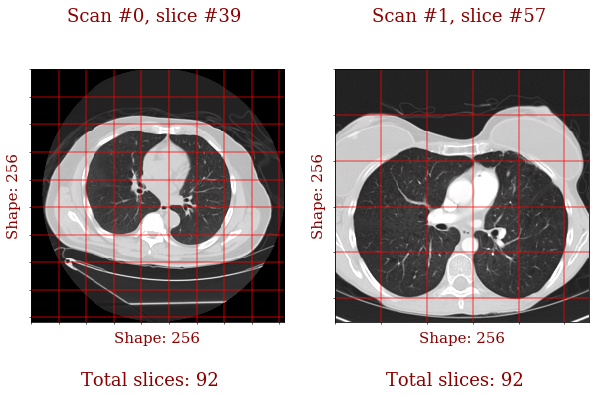

In [13]:
from utils import show_slices
import numpy as np
ixs = np.array(['1.3.6.1.4.1.14519.5.2.1.6279.6001.219618492426142913407827034169',    # indices of two example-scans
                '1.3.6.1.4.1.14519.5.2.1.6279.6001.185154482385982570363528682299'])   # generate small-dataset from subindex
two_scans_dataset = Dataset(index=luna_index.create_subset(ixs), batch_class=CTImagesMaskedBatch)
batch = (two_scans_dataset >> preprocessing).next_batch(2)                             # pass a batch through the workflow
show_slices(batch, scan_indices=[0, 1], ns_slice=[39, 57], grid=True)

As you can see, lungs on the right scan are clearly bigger than on the left one. In this case you may say that left and right scans have different **spacings**: the distance between adjacent pixels on the left scan is lesser than on the right one. In other words, **Luna-dataset** incorporates variability, that is related to peculiarities of *data representation*, rather than *structural differences.* 

Gladly, with action `unify_spacing` from RadIO you can easily make the scans more isotropic:

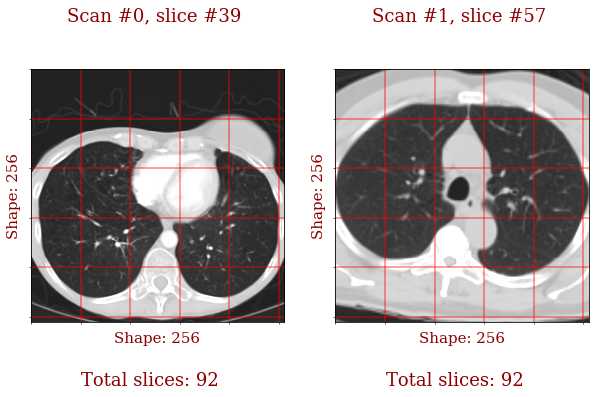

In [15]:
preprocessing = preprocessing.unify_spacing(spacing=(3.5, 1.0, 1.0), shape=(92, 256, 256))
batch = (two_scans_dataset >> preprocessing).next_batch(2)
show_slices(batch, scan_indices=[0, 1], ns_slice=[39, 57], grid=True)

### some more augmenting actions

### preparing a target-tensor for a segmenting net